In [ ]:
!pip install nfl_data_py
!pip install pandas
!pip install matplotlib

In [5]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [ ]:
pbp = nfl.import_pbp_data([2023])
# before cleaning data
pbp.shape

In [7]:
# checks for rows where either the 'pass' column equals 1 or the 'rush' column equals 1. The result is a DataFrame containing only these selected plays.
pbp_rp = pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
# removes rows where any of the columns 'epa', 'posteam', or 'defteam' have missing (NaN) values.
pbp_rp = pbp_rp.dropna(subset=['epa', 'posteam', 'defteam'])
pbp_rp.shape

(4218, 384)

In [8]:
pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'pass_epa'})
pass_epa.sort_values('pass_epa', ascending = False)

,posteam,pass_epa
19,MIA,0.529096
11,GB,0.480721
8,DAL,0.337637
18,LV,0.274470
28,SF,0.224288
3,BUF,0.182382
9,DEN,0.170232
29,TB,0.162691
16,LA,0.149403
27,SEA,0.147579


In [9]:
rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'rush_epa'})
epa = pd.merge(pass_epa, rush_epa, on = 'posteam')
rush_epa.sort_values('rush_epa', ascending = False)

,posteam,rush_epa
17,LAC,0.114938
2,BAL,0.058610
1,ATL,0.053944
28,SF,0.037771
27,SEA,0.037319
3,BUF,0.034934
25,PHI,0.033765
16,LA,-0.004004
30,TEN,-0.023112
9,DEN,-0.033659


In [10]:
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
logos.head()

,team_abbr,team_logo_espn
0,ARI,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png
1,ATL,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png
2,BAL,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png
3,BUF,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png
4,CAR,https://a.espncdn.com/i/teamlogos/nfl/500-dark...


In [11]:
logo_paths = []
team_abbr = []
if not os.path.exists("logos"):
    os.makedirs("logos")

for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])

data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
logo_data = pd.DataFrame(data)

epa_with_logos = pd.merge(epa, logo_data, left_on = 'posteam', right_on = 'team_abbr')

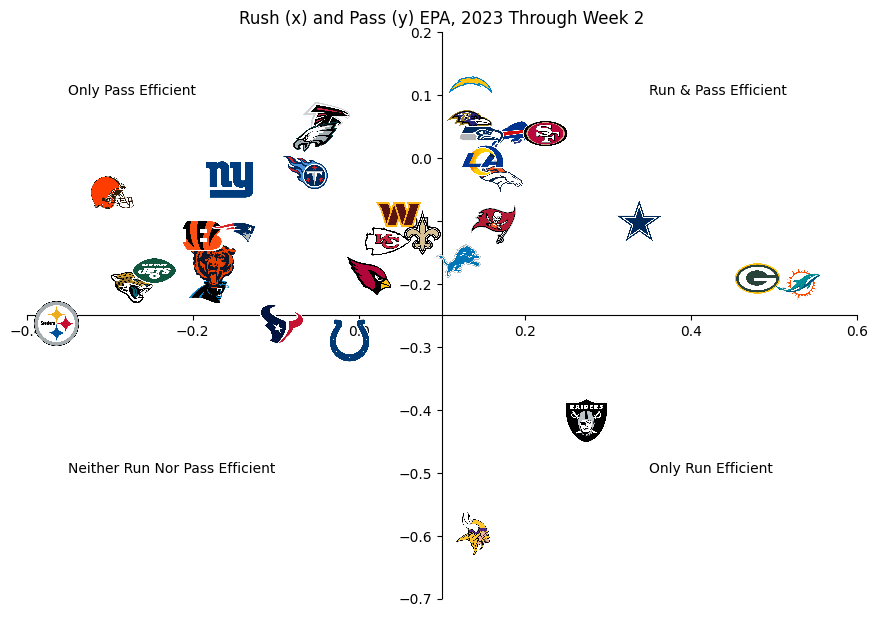

In [13]:
plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.07)

x = epa_with_logos['pass_epa']
y = epa_with_logos['rush_epa']
paths = epa_with_logos['logo_path']

fig, ax = plt.subplots()

for x0, y0, path in zip(x, y, paths):
   ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
   ax.add_artist(ab)

plt.xlim(-0.4, 0.6)
plt.ylim(-0.7, 0.2)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.annotate("Run & Pass Efficient", (0.35, 0.1), fontsize=10)
plt.annotate("Only Pass Efficient", (-0.35, 0.1), fontsize=10)
plt.annotate("Neither Run Nor Pass Efficient", (-0.35, -0.5), fontsize=10)
plt.annotate("Only Run Efficient", (0.35, -0.5), fontsize=10)

plt.title("Rush (x) and Pass (y) EPA, 2023 Through Week 2")
plt.show()